## Params

In [1]:
gg_colab = True #on google colab?
load_pretrain = True #Variable to avoid training and load 
_epochs = 10
_BatchSize = 64
_hiddenNeurons = 512
_opt='adam'
_loss='sparse_categorical_crossentropy' 
#_loss='kullback_leibler_divergence'

#if _hiddenNeurons set to another value than 512 can't load pretrained weights 
if (_hiddenNeurons!=512):
  load_pretrain = False

We choose sparse categorical crossentropy loss because it gives better result than kullback leibler divergence

### Google Colab?

In [2]:
if(gg_colab):
  from google.colab import drive
  drive.mount('/content/drive/')
  %cd 'drive/MyDrive/ZAMA/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ZAMA


### Requirements installation

In [3]:
%pip install -r requirements.txt

## Librairies

In [4]:
import tensorflow as tf
import larq
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import to_categorical
import time

## Dataset

We decided to work with mnist dataset of handwritten digits.

In [5]:
(X_train, Y_train), (X_test, Y_test) = load_data()
Y_train_t, Y_test_t  = Y_train,Y_test
if(_loss == "kullback_leibler_divergence"):
  Y_train_t = to_categorical(Y_train)
  Y_test_t = to_categorical(Y_test)

In [6]:
len(X_train), len(X_test)

(60000, 10000)

### Dataset Overview

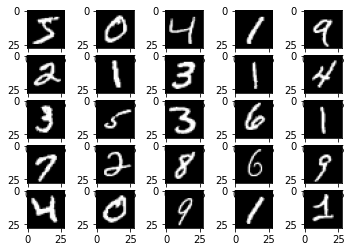

In [7]:
for i in range(25):
	plt.subplot(5, 5, i+1)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

analyse 

### Normalization of pixels value
between $[0,1]$


In [8]:
#norm = np.max(X_train)
norm = 255 #grayscale
norm

255

In [9]:
X_train, X_test = X_train/norm , X_test/norm

## Binary Neural Network Model

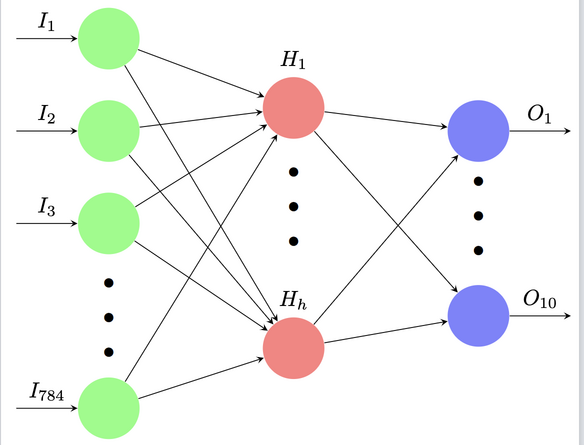

where $h = \_hiddenNeurons$



- Let $W^{(1)} \in \mathcal{M}_{h, 784}$ the matrix between first and hidden layer. In clear, each element of the matrix $W^{(1)}_{i,j}$ ($i \in [1, h]$ and $j \in [1, 784]$) is the weight of the edge linking neuron $I_j$ and $H_i$ and $b^{(1)}$ the corresponding bias.



- Same we define $W^{(2)} \in \mathcal{M}_{10, h}$ the matrix between hidden layer and output layer, in clear $W^{(2)}_{i,j}$($i \in [1, 10]$ and $j \in [1, h]$) is the weight of the edge relying neuron $H_j$ and $O_i$.

- $\forall i \in \{0, 1, 2\}$,  
We define $z_i$ the output vector of the $(i+1)^{th}$ layer (Recall that input layer is the first layer).
Particulary, $z_0$ ,the flatten vector of the grayscale matrix of the input image (size=$28 \times 28$) is the output of the first layer.

- $\forall i \in \{1, 2\}$,  
We define also $\sigma^{(i)}$ the activation function at layer $(i+1)^{th}$.
Notice: $\sigma^{(i)}$ is a multivariate function.

- Finally we define $Q_{kernel}^{(i)}$ and $Q_{input}^{(i)}$ respectively the kernel and  input quantizer between $i^{th}$ and $(i+1)^{th}$ layers.


Therefore we have $\forall i \in \{1, 2\}$:

$z_{i} = \sigma_i \big( Q_{kernel}^{(i)}(W^{(i)}) \, Q_{input}^{(i)}(z_{i-1}) + b^{(i)}\big)$

Recall: $z_{i-1}$ is output of $i^{th}$ layer therefore input of $(i+1)^{th}$ layer 

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

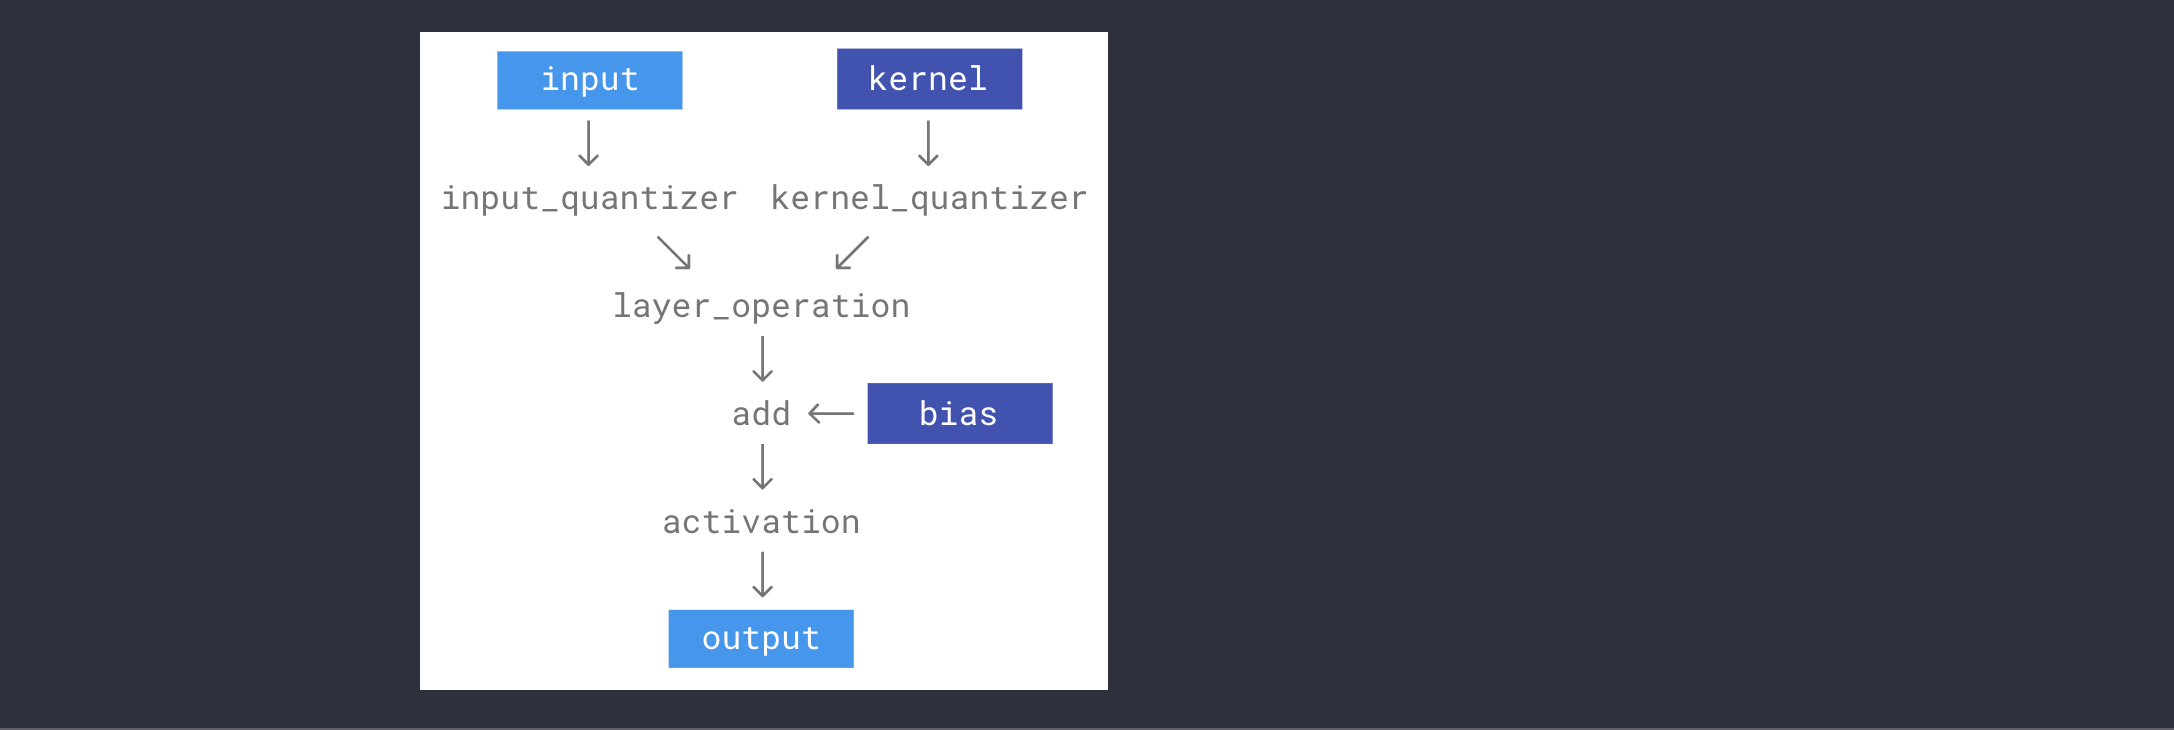

In our binary neural network we take $\sigma^{(1)}=$ Identity , $\sigma^{(2)}=$softmax, $Q_{kernel}^{(1)} = Q_{kernel}^{(2)} = ste\_sign$ (take a matrix as input)
$Q_{input}^{(2)} = ste\_sign$ (take a vector as input)

$ste\_sign$ is a function that binarize all the components through this function:

\begin{equation*}
q(x) = \left\{
        \begin{array}{ll}
            -1 & \quad if \quad x < 0 \\
            1 & \quad if \quad x \geq 0
        \end{array}
    \right.
\end{equation*}

We also define kernel_constraint=$weight_clip$ constrain the non-quantized weights to be between $-1$ and $1$ to avoid stop learning (avoid $\frac{\partial q(x)}{\partial x} (W_{i,j}) =0$).

Recall that when using $Q_{kernel}= ste\_sign$ as quantizer, we also define:
\begin{equation*}
\frac{\partial q(x)}{\partial x} = \left\{
        \begin{array}{ll}
            1 & \quad if \quad \lvert x \rvert \leq 1 \\
            0 & \quad if \quad \lvert x \rvert > 1
        \end{array}
    \right.
\end{equation*}

In [10]:
n_classes = 10
_, size_x, size_y = np.shape(X_train)
n_input = size_x*size_y
x = tf.keras.Input(shape=(size_x, size_y, 1))
y = tf.keras.layers.Flatten()(x)
y = larq.layers.QuantDense(
    _hiddenNeurons, kernel_quantizer="ste_sign", kernel_constraint="weight_clip"
)(y)
y = larq.layers.QuantDense(
    10,
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    activation="softmax",
)(y)
model = tf.keras.Model(inputs=x, outputs=y)

In [11]:
model.compile(optimizer=_opt, loss=_loss, metrics=['accuracy'])

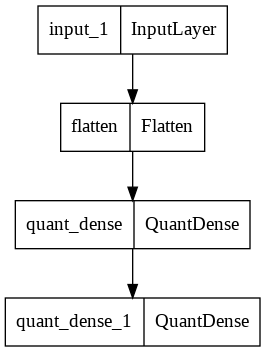

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 quant_dense (QuantDense)    (None, 512)               401920    
                                                                 
 quant_dense_1 (QuantDense)  (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [14]:
if(load_pretrain):
  model.load_weights('my_weights.model')
  _, train_ac = model.evaluate(X_train, Y_train_t)
  _, test_ac = model.evaluate(X_test, Y_test_t)
  print(f"Accuracy over train dataset: {train_ac * 100:.2f} %")
  print(f"Accuracy over test dataset: {test_ac * 100:.2f} %")
else:
  model.fit(X_train, Y_train_t, epochs=_epochs, batch_size=_BatchSize)
  model.save_weights('my_weightstmp.model')
  test_loss, test_acc = model.evaluate(X_test, Y_test_t)
  print(f"Accuracy over test dataset: {test_acc * 100:.2f} %")

313/313 [==============================] - 4s 11ms/step - loss: 1.0931 - accuracy: 0.9115
Accuracy over train dataset: 91.36 %
Accuracy over test dataset: 91.15 %


When training We also tried kullback leibler divergence loss but it doesn't give good results

# Inference

#### Load weights of our trained binary neural network

In [15]:
weights = [layer.get_weights() for layer in model.layers]
weights_abs =[np.absolute(weights[i][0]) for i in range(2,4)]

#### define function to perform accuracy

In [16]:
def quantizer(X):
  res = np.zeros(np.shape(X))
  if len(np.shape(X)) == 2:
    n,m = np.shape(X)
    for i in range(n):
      for j in range(m):
        if X[i][j]<0:
          res[i][j] = -1
        else:
          res[i][j]=1
  else:
    for i in range(len(X)):
      if X[i]<0:
        res[i]= -1
      else:
        res[i]=1
  return res

def softMax(X):
  s = sum([np.exp(z) for z in X])
  for i in range(len(X)):
    X[i]= np.exp(X[i])/s

#prediction of one input
def pred1(x, We1, b1, We2, b2):
  x = x.flatten()
  y1 = We1.T@x+b1
  y1 = quantizer(y1)
  y2 = We2.T@y1+b2
  softMax(y2)
  return y2

#prediction of an array of input
def pred2(X, We1,b1, We2,b2):
  x = X[0].flatten()
  x=x.reshape(1,len(x))
  b1 = np.tile(b1,(len(X), 1))
  b2 = np.tile(b2,(len(X), 1))
  n = len(X)
  x = np.block([X[i].flatten().reshape(n_input,1) for i in range(n)])
  print("first step ok")
  y1 = We1.T@x+b1.T
  y1 =quantizer(y1)
  y2 = We2.T@y1+b2.T
  softMax(y2)
  return y2.transpose()
def eval1(We1, b1, We2, b2,X=X_train, Y=Y_train):
  deb=time.time()
  acc = 0
  n=len(Y)
  for i in range(n):
    print(end='\r')
    print("{:.0%}".format(i/(n-1)), end='')
    yi = pred1(X[i], We1, b1, We2, b2)
    if(np.argmax(yi)==Y[i]):
      acc+=1
  print()
  print("{:.2f}".format(time.time()-deb),"s")
  return acc/n
def eval2(We1, b1, We2, b2, X=X_train, Y=Y_train):
  deb=time.time()
  acc = 0
  n=len(Y)
  Y_hat = pred2(X, We1,b1, We2,b2)
  for i in range(n):
    
    yi = Y_hat[i]
    if(np.argmax(yi)==Y[i]):
      acc+=1
  print()
  print("{:.2f}".format(time.time()-deb),"s")
  return acc/n

In [17]:
import copy
W1 = copy.deepcopy(weights[2][0])
b1 = copy.deepcopy(weights[2][1])
We1 = quantizer(W1)
W2=copy.deepcopy(weights[3][0])
We2 = quantizer(W2)
b2 = copy.deepcopy(weights[3][1])

In [18]:
#Test Eval
a = eval2(We1, b1, We2, b2)
print(f"Accuracy over train dataset with our eval function: {a * 100:.2f} %")

first step ok

51.54 s
Accuracy over train dataset with our eval function: 91.36 %


In [19]:
#Test Eval
a = eval2(We1, b1, We2, b2,X=X_test, Y=Y_test)
print(f"Accuracy over test dataset with our eval function: {a * 100:.2f} %")

first step ok

5.96 s
Accuracy over test dataset with our eval function: 91.15 %


In [20]:
#Test Eval
a = eval1(We1, b1, We2, b2,X=X_test, Y=Y_test)
print(f"Accuracy over test dataset with our eval function: {a * 100:.2f} %")

100%
16.58 s
Accuracy over test dataset with our eval function: 91.15 %


As we can see eval2 is faster than eval1 (logic)

In [21]:
pred1(X_train[0], We1, b1, We2, b2)

array([1.16596146e-27, 6.53884480e-26, 7.20539427e-33, 9.17278052e-14,
       4.38710991e-38, 1.00000000e+00, 1.47010858e-41, 2.59743951e-23,
       4.61529787e-25, 1.03762151e-20])

In [22]:
pred2(X_train[0:2] , We1, b1, We2, b2) 

first step ok


array([[1.16596146e-27, 6.53884480e-26, 7.20539427e-33, 9.17278052e-14,
        4.38710991e-38, 1.00000000e+00, 1.47010858e-41, 2.59743951e-23,
        4.61529787e-25, 1.03762151e-20],
       [1.00000000e+00, 1.64737346e-28, 2.62539273e-23, 5.36031965e-32,
        6.79103185e-46, 1.20448126e-27, 2.92458244e-30, 1.19855661e-27,
        6.34846454e-26, 1.60618741e-28]])

In [23]:
model.predict(X_train[0:2])

array([[1.1659580e-27, 6.5388169e-26, 7.2053601e-33, 9.1727448e-14,
        4.3871146e-38, 1.0000000e+00, 0.0000000e+00, 2.5974359e-23,
        4.6152771e-25, 1.0376179e-20],
       [1.0000000e+00, 1.6473650e-28, 2.6253883e-23, 5.3603148e-32,
        0.0000000e+00, 1.2044802e-27, 2.9245794e-30, 1.1985539e-27,
        6.3484302e-26, 1.6061865e-28]], dtype=float32)

### Overview on the weigths distribution

In [24]:
m,n = np.shape(weights_abs[0])
np.mean(weights_abs[0]),np.std(weights_abs[0])

(0.0551171, 0.047546167)

In [25]:
np.max(weights_abs[0]), np.min(weights_abs[0])

(0.57207036, 1.8487111e-07)

#### Remove edge with $\lvert weight \rvert$ less than $threshold$ like a dropout.

This will permit us to avoid overfitting and also optimize the inference phase since we have less edges

In [26]:
#return set of index with weight less than threshold
def index(W, threshold):
  res = []
  if(len(np.shape(W))==2):
    m,n = np.shape(W)
    for i in range(m):
      for j in range(n):
        if W[i][j] < threshold:
          res.append((i, j))
  else:
    for i in range(len(W)):
      if W[i] < threshold:
          res.append(i)
  return res

#quantizer1 differ to quantizer2 when the weigth is equal to 0
def quantizer2(X):
    res = np.zeros(np.shape(X))
    if len(np.shape(X)) == 2:
      n,m = np.shape(X)
      for i in range(n):
        for j in range(m):
          if X[i][j]<0:
            res[i][j] = -1
          elif X[i][j]>0:
            res[i][j]=1
    return res

In [27]:
#I did somme test to find 5000
threshold1 = np.mean(weights_abs[0])/5000
W1 = copy.deepcopy(weights[2][0])
b1 = copy.deepcopy(weights[2][1])
W2 = copy.deepcopy(weights[3][0])
b2 = copy.deepcopy(weights[3][1])
tmp1 = index(weights_abs[0], threshold1)
for i in tmp1:
  W1[i] = 0
print(len(tmp1), "edges remove between layer 1(Input layer) and layer 2(Hidden layer)")
We1 = quantizer2(W1)
We2 = quantizer(W2)

49 edges remove between layer 1(Input layer) and layer 2(Hidden layer)


We don't remove edges between the hidden layers and last layer because fully connected is required since it is the last step before classifying 

In [28]:
pred1(X_train[0], We1, b1, We2, b2)

array([1.16596146e-27, 6.53884480e-26, 7.20539427e-33, 9.17278052e-14,
       4.38710991e-38, 1.00000000e+00, 1.47010858e-41, 2.59743951e-23,
       4.61529787e-25, 1.03762151e-20])

In [29]:
#Eval
a = eval2(We1, b1, We2, b2)
print(f"Accuracy over train dataset with our (little)optimization: {a * 100:.2f} %")

first step ok

57.03 s
Accuracy over train dataset with our (little)optimization: 91.35 %


#### Evaluation on the Test Dataset

In [30]:
a = eval2(We1, b1, We2, b2, X=X_test, Y=Y_test)
print(f"Accuracy over test dataset of our (little)optimization: {a * 100:.2f} %")

first step ok

5.96 s
Accuracy over test dataset of our (little)optimization: 91.16 %


## Perspective

Our accuracy (91%) is not optimal since after looking some results, we can see that it is possible to do much better (99% accuracy).
Therefore what we could do later is to improve our result, by adding more layers, using convolutionnal neural network which is more efficient for image classification due to local correlation of pixels ...

### Working on this project :)

I really appreciate to work on this project since it permits me to better understanf binary neural network even if I didn't know anything about it before.

It also permits me to learn another machine lerning problem such as *how to improve a neural network after training?*